# Image classification with small data

1. Download and setup dataset (Kaggle Cats & Dogs) https://www.kaggle.com/c/dogs-vs-cats/data
2. Train a small convnet on our small data (acc ~ 0.75)
3. Train a MLP using bottleneck features of pretrained model (acc ~ 0.90)
4. Finetuning top layers of pretrained model on our small data (acc ~ 0.94)


In [1]:
# imports
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras import applications
import numpy as np
from keras import Model
from keras import losses
from keras import optimizers
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# define plot & parse functions
def parse_log_file(pfile):
    f= open(pfile).readlines()
    lines = [i.strip() for i in f]
    log= {k:[] for k in ['acc','val_acc','loss','val_loss']}
    for l in lines:
        if 'loss' in l:
            for k in log.keys():
                log[k].append(float(l.split(k+': ')[1].split(' -')[0]))
    return log 

def plot_loss_acc(pfile):
    history = parse_log_file(pfile)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    plt.plot(history['acc'])
    plt.plot(history['val_acc'])
    plt.title('model acc')
    plt.ylabel('acc')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [3]:
img_width, img_height = 150, 150
input_shape = (img_width, img_height, 3)

## Train a small convnet on our small data

In [4]:
# define a sequential model (small conv net): 
# 3 conv blocks (Conv2D, Activation('relu'), MaxPooling2D) + 2 dense layers
# Conv_1: filters 32, kernel size(3,3)
# Conv_2: filters 32, kernel size(3,3)
# Conv_3: filters 64, kernel size(3,3)
# Flatten
# Dense_1: 64
# Activation('relu')
# Dropout(0.5)
# Dense_2:  ? 
# Activation('sigmoid')

# print model summary

# # add your implementation
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (3, 3), input_shape = input_shape))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(filters = 32, kernel_size = (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(filters = 64, kernel_size = (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Flatten())
model.add(Dense(units = 64, activation = "relu"))
model.add(Dropout(rate = 0.5))
model.add(Dense(units = 1, activation = "sigmoid"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)        18496     
__________

In [5]:
# compile model 
# use binary crossentropy loss 
# and rmsprop optimizer

# # add your implementation
model.compile(loss = losses.binary_crossentropy,
              optimizer = optimizers.RMSprop(),
              metrics = ['accuracy'])

In [6]:
train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 50
batch_size = 16

In [7]:
# define a keras ImageDataGenerator for training data with appropriate augmentation 
# use rescale=1. / 255 to normalise pixles values

# define a keras ImageDataGenerator for test data  (no augmentation only rescaling)

# # add your implementation
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 2,
    horizontal_flip = True,
    zoom_range = 0.1)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [8]:
# define training and validation iterators 
# use ImageDataGenerator.flow_from_directory to training and validation dirs accordingly 

# # add your implementation
train_iterator = train_datagen.flow_from_directory(directory = train_data_dir, target_size = (img_height, img_width), 
                                                       batch_size = batch_size, class_mode = "binary")
test_iterator = test_datagen.flow_from_directory(directory = validation_data_dir, target_size = (img_height, img_width), 
                                                       batch_size = batch_size, class_mode = "binary")

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


Found 2000 images belonging to 2 classes.


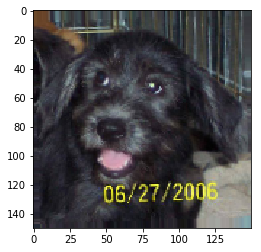

In [9]:
for x_batch, y_batch in train_datagen.flow_from_directory(directory = train_data_dir, target_size = (img_height, img_width), batch_size = 1):
    plt.imshow(np.array(x_batch[0]))
    break

In [10]:
# train and validate the model using fit_generator

# # add your implementation
model.fit_generator(generator = train_iterator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data = test_iterator,
                    validation_steps = nb_validation_samples // batch_size,
                    epochs = epochs,
                    workers = 8)

Epoch 1/50
125/125 [==============================] - 6s 45ms/step - loss: 0.7480 - acc: 0.5310 - val_loss: 0.6756 - val_acc: 0.6250
Epoch 2/50
125/125 [==============================] - 4s 32ms/step - loss: 0.6773 - acc: 0.6020 - val_loss: 0.6260 - val_acc: 0.6325
Epoch 3/50
125/125 [==============================] - 4s 32ms/step - loss: 0.6329 - acc: 0.6475 - val_loss: 0.6171 - val_acc: 0.6462
Epoch 4/50
125/125 [==============================] - 4s 33ms/step - loss: 0.6210 - acc: 0.6745 - val_loss: 0.5589 - val_acc: 0.7125
Epoch 5/50
125/125 [==============================] - 4s 31ms/step - loss: 0.6187 - acc: 0.6845 - val_loss: 0.6182 - val_acc: 0.6875
Epoch 6/50
125/125 [==============================] - 4s 32ms/step - loss: 0.5618 - acc: 0.7105 - val_loss: 0.6295 - val_acc: 0.6850
Epoch 7/50
125/125 [==============================] - 4s 32ms/step - loss: 0.5501 - acc: 0.7370 - val_loss: 0.6046 - val_acc: 0.6462
Epoch 8/50
125/125 [==============================] - 4s 32ms/step - 

## Train a MLP using bottleneck features

In [11]:
# define VGG16 network using keras applications.VGG16  
# set weights = 'imagenet'
# set include_top=False : don't include the fully-connected layer at the top of the network 
# set input_shape: image shape

# # add your implementation
from keras.applications.vgg16 import VGG16
vgg16 = VGG16(weights = "imagenet", include_top = False, input_shape = input_shape)

# define a keras ImageDataGenerator for data (no augmentation only rescaling)
# define training and validation iterators same as before (set shuffle=False)

# # add your implementation
datagen_bottleneck = ImageDataGenerator(rescale = 1./255)
train_iterator_bottleneck = datagen_bottleneck.flow_from_directory(directory = train_data_dir, target_size = (img_height, img_width), 
                                                  batch_size = batch_size, shuffle = False)
test_iterator_bottleneck = datagen_bottleneck.flow_from_directory(directory = validation_data_dir, target_size = (img_height, img_width),
                                                  batch_size = batch_size, shuffle = False)

# extract image features for training and validation separately using predict_generator

# # add your implementation
# # add your implementation
train_preds = vgg16.predict_generator(train_iterator_bottleneck, steps = nb_train_samples // batch_size)
test_preds = vgg16.predict_generator(test_iterator_bottleneck, steps = nb_validation_samples // batch_size)

# save training and validation features

# # add your implementation
np.save("bottleneck_features_train.npy", train_preds)
np.save("bottleneck_features_validation.npy", test_preds)

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [12]:
# create training and validation labels array (features are in order because we used shuffle=false) 

# # add your implementation
train_labels = np.vstack((np.zeros((1000, 1)), np.ones((1000, 1))))
test_labels = np.vstack((np.zeros((400, 1)), np.ones((400, 1))))

# define model of two dense layers 256 and ? 
# model should start with Flatten layer (to flatten extracted image features to a vector)
# don’t forget activations and dropout(0.5)
# compile with binary_crossentropy loss and rmsprop optimizer

# # add your implementation
train_preds = np.load("bottleneck_features_train.npy")
test_preds = np.load("bottleneck_features_validation.npy")

# Train MLP using fit function

# # add your implementation
model_bottleneck = Sequential()
model_bottleneck.add(Flatten(input_shape = (4, 4, 512)))
model_bottleneck.add(Dense(units = 256))
model_bottleneck.add(Activation("relu"))
model_bottleneck.add(Dropout(rate = 0.5))
model_bottleneck.add(Dense(units = 1))
model_bottleneck.add(Activation("sigmoid"))
model_bottleneck.summary()

model_bottleneck.compile(loss = losses.binary_crossentropy,
              optimizer = optimizers.RMSprop(),
              metrics = ['accuracy'])

model_bottleneck.fit(x = train_preds, y = train_labels, steps_per_epoch = nb_train_samples // batch_size,
                    validation_data = (test_preds, test_labels), validation_steps = nb_validation_samples // batch_size,
                    epochs = epochs)

# save weights to use them in fine-tuning later on

# # add your implementation

model_bottleneck.save_weights("model_on_bottleneck_50epochs.h5")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
activation_4 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
_________________________________________________________________
activation_5 (Activation)    (None, 1)                 0         
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________


## Finetuning top layers of pretrained model on our small data

In [13]:
# define new model:  VGG16 as base and MLP as top 
# input = base_model.input, output=top_model(base_model.output)

# # add your implementation
top_model = Sequential()
top_model.add(Flatten(input_shape = (4, 4, 512)))
top_model.add(Dense(units = 256))
top_model.add(Activation("relu"))
top_model.add(Dropout(rate = 0.5))
top_model.add(Dense(units = 1))
top_model.add(Activation("sigmoid"))
top_model.load_weights("model_on_bottleneck_50epochs.h5")

base_model = VGG16(include_top = False, input_shape = input_shape)
model_finetune = Model(inputs = base_model.input, output = top_model(base_model.output))

# freeze the first 15 layers (up to the last conv block)
# set trainable=false (weights will not be updated)

# # add your implementation
for layer in model_finetune.layers[:15]:
    layer.trainable = False
    
model_finetune.summary()

# compile with binary_crossentropy loss and SGD with low learing rate optimizer

# # add your implementation
model_finetune.compile(loss = losses.binary_crossentropy,
              optimizer = optimizers.SGD(lr = 0.0001, momentum=0.9),
              metrics = ['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`
  from ipykernel import kernelapp as app


In [14]:
# fine-tune the model using fit_generator and train and validation iterators

# # add your implementation
model_finetune.fit_generator(generator = train_iterator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data = test_iterator,
                    validation_steps = nb_validation_samples // batch_size,
                    epochs = epochs)

Epoch 1/50
125/125 [==============================] - 20s 161ms/step - loss: 0.4444 - acc: 0.8780 - val_loss: 0.3314 - val_acc: 0.8875
Epoch 2/50
125/125 [==============================] - 19s 149ms/step - loss: 0.1423 - acc: 0.9475 - val_loss: 0.4180 - val_acc: 0.8875
Epoch 3/50
125/125 [==============================] - 19s 150ms/step - loss: 0.1232 - acc: 0.9530 - val_loss: 0.2717 - val_acc: 0.9000
Epoch 4/50
125/125 [==============================] - 19s 150ms/step - loss: 0.0737 - acc: 0.9740 - val_loss: 0.3204 - val_acc: 0.9062
Epoch 5/50
125/125 [==============================] - 19s 151ms/step - loss: 0.0532 - acc: 0.9825 - val_loss: 0.4414 - val_acc: 0.8950
Epoch 6/50
125/125 [==============================] - 19s 150ms/step - loss: 0.0503 - acc: 0.9835 - val_loss: 0.2853 - val_acc: 0.9075
Epoch 7/50
125/125 [==============================] - 19s 149ms/step - loss: 0.0275 - acc: 0.9890 - val_loss: 0.3488 - val_acc: 0.9250
Epoch 8/50
125/125 [==============================] - 1